In [1]:
 pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload() #upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mirtavucinic","key":"c4136663ac663d4e32c581d094f31cb7"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00


In [8]:
! pip install pydub

In [9]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    LSTM,
    Dropout,
    Dense,
    MaxPooling2D,
    Flatten,
)

import librosa.display
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import random
import os
from pydub import AudioSegment
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve, classification_report
from PIL import Image

In [10]:
! kaggle datasets download birdy654/deep-voice-deepfake-voice-recognition

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition
License(s): other
100% 3.67G/3.69G [00:54<00:00, 57.2MB/s]
100% 3.69G/3.69G [00:54<00:00, 72.9MB/s]


In [11]:
!unzip deep-voice-deepfake-voice-recognition.zip -d /content/dataset

Archive:  deep-voice-deepfake-voice-recognition.zip
  inflating: /content/dataset/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3  
  inflating: /content/dataset/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-Obama.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-Trump.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-linus.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-margot.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-musk.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-ryan.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-taylor.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/linus-to-biden.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/linus-to-margot.wav  
  inflating: /content

In [12]:

dataset_path = "/content/dataset/KAGGLE/AUDIO"
augmented_dataset_path = "/kaggle/working/SPLITTED"

os.makedirs(augmented_dataset_path, exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "FAKE"), exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "REAL"), exist_ok=True)

def split_audio_file(file_path, output_dir, segment_length=10):
    audio = AudioSegment.from_wav(file_path)
    duration = audio.duration_seconds
    segment_length_ms = segment_length * 1000

    segments = []
    for i in range(0, len(audio), segment_length_ms):
        segment = audio[i:i + segment_length_ms]
        segment_file_name = f"{os.path.splitext(os.path.basename(file_path))[0]}_part{i // segment_length_ms}.wav"
        segment_path = os.path.join(output_dir, segment_file_name)
        segment.export(segment_path, format="wav")
        segments.append(segment_path)
    return segments

real_samples_path = os.path.join(dataset_path, "REAL")
for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    output_dir = os.path.join(augmented_dataset_path, "REAL")
    split_audio_file(file_path, output_dir)

fake_samples_path = os.path.join(dataset_path, "FAKE")
fake_segments = []
for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    output_dir = os.path.join(augmented_dataset_path, "FAKE")
    fake_segments.extend(split_audio_file(file_path, output_dir))

selected_fake_segments = random.sample(fake_segments, len(os.listdir("/kaggle/working/SPLITTED/REAL")))

selected_fake_path = os.path.join(augmented_dataset_path, "SELECTED_FAKE")
os.makedirs(selected_fake_path, exist_ok=True)
for segment in selected_fake_segments:
    segment_file_name = os.path.basename(segment)
    os.rename(segment, os.path.join(selected_fake_path, segment_file_name))

<ipython-input-13-da10bd04fdfc>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=data_pre_augmentation, ax=axes[0], palette=['#1f77b4', '#ff7f0e'])
<ipython-input-13-da10bd04fdfc>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=data_post_augmentation, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])


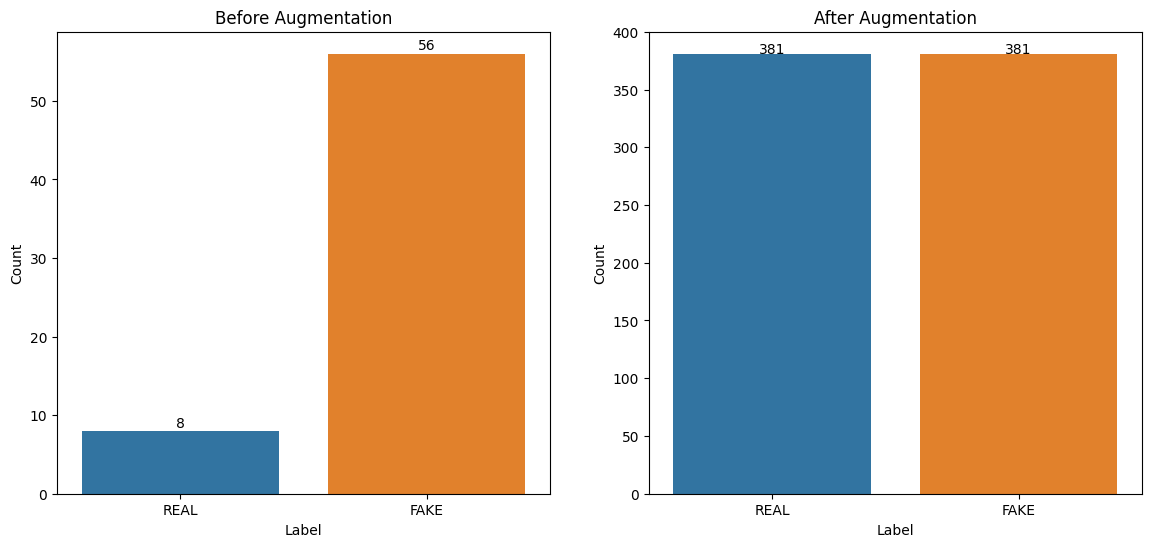

In [13]:

original_real_path = os.path.join(dataset_path, "REAL")
original_fake_path = os.path.join(dataset_path, "FAKE")
augmented_real_path = os.path.join(augmented_dataset_path, "REAL")
augmented_fake_path = os.path.join(augmented_dataset_path, "SELECTED_FAKE")

num_original_real = len(os.listdir(original_real_path))
num_original_fake = len(os.listdir(original_fake_path))


num_augmented_real = len(os.listdir(augmented_real_path))
num_augmented_fake = len(os.listdir(augmented_fake_path))


data_pre_augmentation = {'Label': ['REAL', 'FAKE'], 'Count': [num_original_real, num_original_fake]}
data_post_augmentation = {'Label': ['REAL', 'FAKE'], 'Count': [num_augmented_real, num_augmented_fake]}


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.barplot(x='Label', y='Count', data=data_pre_augmentation, ax=axes[0], palette=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Before Augmentation')
for i, count in enumerate(data_pre_augmentation['Count']):
    axes[0].text(i, count + 0.5, str(count), ha='center')


sns.barplot(x='Label', y='Count', data=data_post_augmentation, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])
axes[1].set_title('After Augmentation')
for i, count in enumerate(data_post_augmentation['Count']):
    axes[1].text(i, count + 0.5, str(count), ha='center')

plt.show()

In [14]:

def extract_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

fake_samples_path = "/kaggle/working/SPLITTED/SELECTED_FAKE"
real_samples_path = "/kaggle/working/SPLITTED/REAL"

features = []
labels = []

for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_features(file_path))
        labels.append(0)


for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_features(file_path))
        labels.append(1)

X = np.array(features)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=144
  warnings.warn(


In [15]:
model_accuracy={}

# Naive Bayes

In [16]:
model = GaussianNB()


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Naive Bayes"] = accuracy

Accuracy: 0.9150326797385621
Precision: 0.8987341772151899
Recall: 0.9342105263157895
F1-score: 0.9161290322580645


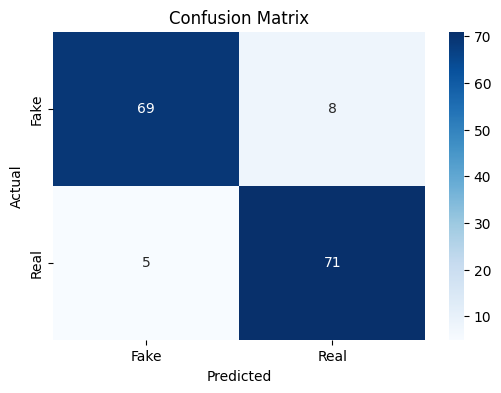

In [17]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        77
           1       0.90      0.93      0.92        76

    accuracy                           0.92       153
   macro avg       0.92      0.92      0.92       153
weighted avg       0.92      0.92      0.92       153



# K-Nearest Neighbors (KNN)



In [19]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Best parameters: {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'uniform', 'selector__k': 11}
Best score: 0.9934426229508198


In [20]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [21]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["SVM"] = accuracy

Accuracy: 0.9150326797385621
Precision: 0.987012987012987
Recall: 1.0
F1-score: 0.9934640522875817


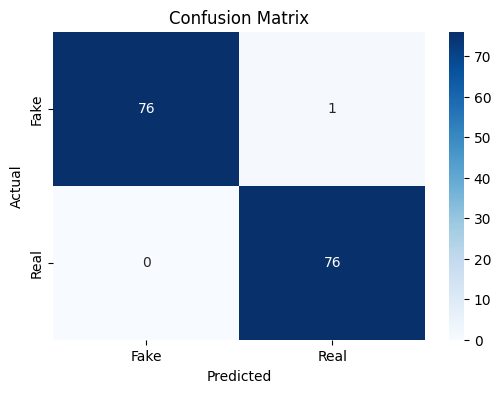

In [22]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        77
           1       0.99      1.00      0.99        76

    accuracy                           0.99       153
   macro avg       0.99      0.99      0.99       153
weighted avg       0.99      0.99      0.99       153



# Support Vector Machine (SVM)

In [24]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('svm', SVC(probability=True))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['linear', 'rbf']
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Best parameters: {'selector__k': 13, 'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best score: 0.9934426229508198


In [25]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [26]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["SVM"] = accuracy

Accuracy: 0.9934640522875817
Precision: 0.987012987012987
Recall: 1.0
F1-score: 0.9934640522875817


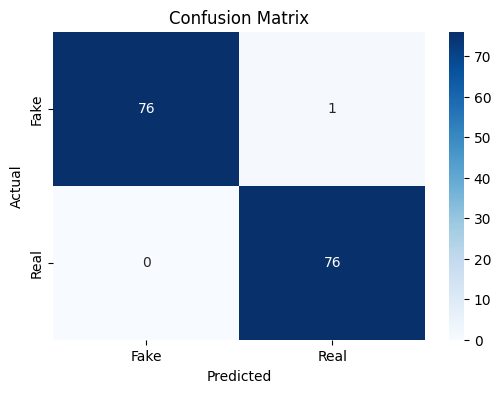

In [27]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        77
           1       0.99      1.00      0.99        76

    accuracy                           0.99       153
   macro avg       0.99      0.99      0.99       153
weighted avg       0.99      0.99      0.99       153



# Logistic Regression

In [29]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear', 'saga']
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters: {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'selector__k': 13}
Best score: 0.8489229101747731


In [30]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Logistic Regression"] = accuracy

Accuracy: 0.8169934640522876
Precision: 0.8076923076923077
Recall: 0.8289473684210527
F1-score: 0.8181818181818182


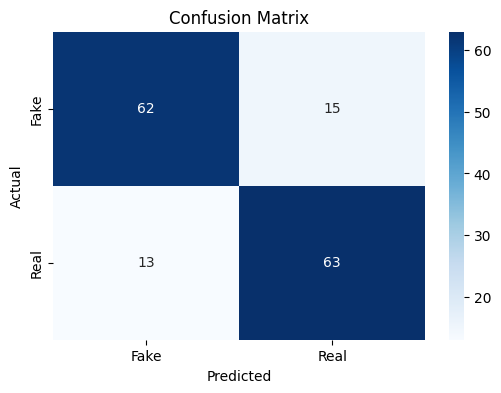

In [31]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        77
           1       0.81      0.83      0.82        76

    accuracy                           0.82       153
   macro avg       0.82      0.82      0.82       153
weighted avg       0.82      0.82      0.82       153



# Random Forest

In [33]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__bootstrap': [True, False]
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)


grid_search.fit(X_train, y_train)


print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

KeyboardInterrupt: 

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Random Forest"] = accuracy

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

# Decision Tree

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'dt__max_depth': [None, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Decision Tree"] = accuracy

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

# CatBoost

In [ ]:
catboost= CatBoostClassifier(verbose=0, random_state=42)

catboost.fit(X_train, y_train)

y_pred = catboost.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["CatBoost"] = accuracy

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

# eXtreme Gradient Boosting (XGB)

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["XGB"] = accuracy

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

# Long Short-Term Memory (LSTM)

In [ ]:
def extract_mfcc_sequence(file_path, n_mfcc=13, max_length=100):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs = mfccs.T
    mfccs = pad_sequences([mfccs], maxlen=max_length, padding='post', truncating='post')[0]
    return mfccs

features = []
labels = []

for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_mfcc_sequence(file_path))
        labels.append(0)

for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_mfcc_sequence(file_path))
        labels.append(1)


X = np.array(features)
y = np.array(labels)

X_reshaped = X.reshape(X.shape[0], -1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])

y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))
model.add(LSTM(32,kernel_regularizer=l2(0.0001)))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
model_accuracy["LSTM"] = accuracy

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Convolutional Neural Network (CNN)

In [ ]:
def save_spectrogram(file_path, output_dir, n_mels=128, fmax=8000):
    y, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=(3, 3))
    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel', fmax=fmax)
    plt.axis('off')
    output_path = os.path.join(output_dir, os.path.basename(file_path).replace('.wav', '.png'))
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

fake_output_dir = "/kaggle/working/SPECTROGRAMS/FAKE"
real_output_dir = "/kaggle/working/SPECTROGRAMS/REAL"
os.makedirs(fake_output_dir, exist_ok=True)
os.makedirs(real_output_dir, exist_ok=True)

for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        save_spectrogram(file_path, fake_output_dir)

for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        save_spectrogram(file_path, real_output_dir)


In [ ]:
def display_real_fake_pairs(real_dir, fake_dir, num_pairs=5):
    real_files = [f for f in os.listdir(real_dir) if f.endswith('.png')]
    fake_files = [f for f in os.listdir(fake_dir) if f.endswith('.png')]

    pairs = []
    for real_file in real_files:
        real_base_name = real_file.split('-original_part')[0]
        part_number = real_file.split('_part')[-1].split('.png')[0]

        matching_fake = next(
            (f for f in fake_files if f.startswith(f"{real_base_name}-to-") and f.endswith(f"_part{part_number}.png")),
            None
        )

        if matching_fake:
            pairs.append((real_file, matching_fake))
        if len(pairs) >= num_pairs:
            break

    if not pairs:
        print("There are no spectrogram pairs available to display.")
        return

    plt.figure(figsize=(20, 2*len(pairs)))

    for i, (real_file, fake_file) in enumerate(pairs):
        real_path = os.path.join(real_dir, real_file)
        fake_path = os.path.join(fake_dir, fake_file)

        real_img = Image.open(real_path)
        fake_img = Image.open(fake_path)

        plt.subplot(2, len(pairs), i + 1)
        plt.imshow(real_img)
        plt.title(f"Real: {real_file}")
        plt.axis('off')

        plt.subplot(2,len(pairs), i + 6)
        plt.imshow(fake_img)
        plt.title(f"Fake: {fake_file}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_real_fake_pairs(real_output_dir, fake_output_dir)

In [ ]:
train_dir = "/kaggle/working/SPECTROGRAMS"
batch_size = 32
img_height, img_width = 128, 128

train_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
model_accuracy["CNN"] = accuracy

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
models = list(model_accuracy.keys())
accuracies = list(model_accuracy.values())

max_index = accuracies.index(max(accuracies))
colors = ['green' if i == max_index else 'red' for i in range(len(models))]

plt.figure(figsize=(20, 7))
plt.bar(models, accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.5f}", ha='center', va='bottom')
plt.show()